In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from statistics import mean
titles = ['SOLID','LIQUID','GAS']
phases = ['solid','liquid','gas']
quantities = ['potential energy per atom','pressure']
quants = ['U/N','P']
units = ['J','Pa']

# NSL_7

In this notebook the canonical ensamble will be simulated exploiting the Metropolis algorithm to sample the Boltzmann's weight. The physical system simulated is a box of $108$ atoms in solid, liquid and gas phase. The three phases are obtained varying the density and the temperature of the system. These are the three configurations (in LJ units):
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

Every atom interacts with the others through a Lennard-Jones potential cut at a cut-off radius  $r_c$ that depends on the considered phase. A cut-off radius is necessary to avoid an atom to interact with itself through the periodic boundary conditions.

The physical quantities of interest in this notebook are the internal energy and the pressure of the system. This time, a tail correction is introduced to compensate the cut-off of the potential.

### EX07_1

#### ENERGY AND PRESSURE

In [2]:
%%time
en_solid, pres_solid = np.loadtxt('instant_values/instasolid.txt', usecols=(1,2), unpack=True, skiprows=500)
en_liquid, pres_liquid = np.loadtxt('instant_values/instaliquid.txt', usecols=(1,2), unpack=True, skiprows=500)
en_gas, pres_gas = np.loadtxt('instant_values/instagas.txt', usecols=(1,2), unpack=True, skiprows=500)
en = [en_solid, en_liquid, en_gas]
pres = [pres_solid, pres_liquid, pres_gas]


CPU times: user 7.73 s, sys: 185 ms, total: 7.91 s
Wall time: 10.6 s


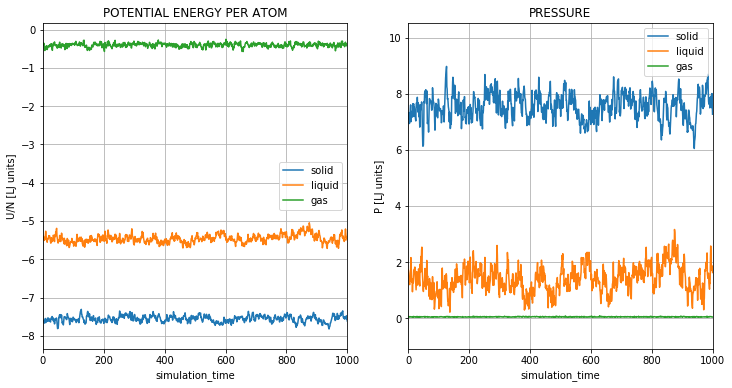

In [4]:
fig, axx = plt.subplots(1, 2,figsize=(12, 6))
t = np.linspace(0, len(en_solid), len(en_solid))
quant = [en,pres]

for i,ax in enumerate(axx):
    ax.plot(t, quant[i][0], label = phases[0])
    ax.plot(t, quant[i][1], label = phases[1])
    ax.plot(t, quant[i][2], label = phases[2])
    ax.set_xlabel("simulation_time")
    ax.set_ylabel(quants[i]+" [LJ units]")
    ax.set_xlim(0, 1000)
    ax.legend(loc='best')
    ax.set_title(quantities[i].upper())
    ax.grid()

These are the first two graphs of the notebook. They represent the istantaneous potential energy per atom and pressure of the various phases after equilibration. Here are represented only the first $1000$ steps of the total $5*10^5$ steps of each simulation. In general, $500$ Metropolis steps were enough to equilibrate the system.

It is noticeable that the potential energy is closer to zero in the gas phase. This is beacuse gas particle tends to stay away from each other preferring kinetic energy to potential one. The same is valid for the pressure: the solid phase has a pressure much higher than the liquid and the gas phase.

NB: before this simulation the three phases have been tested in order to find an optimal step for the Metropolis algorithm to maintain the $50\%$ empirical rule. These are the selected steps (LJ units):
- solid phase: 0.11
- liquid phase: 0.21
- gas phase: 5

It was not possible to reach a $50\%$ accepatance rate for the gas phase because of the boundary condition. The best rate was around $60\%$.

#### AUTOCORRELATION

In [126]:
def auto(vect, tn):
    auto = []
    tmax = len(vect)-1
    sum1 = np.sum([ vect[tt]*vect[tt] for tt in range(0,tmax+1)])
    sum4 = np.sum(vect[0:tmax])
    sum5 = np.sum([i**2 for i in vect[0:tmax]])
    sum2 = np.sum(vect[0:tmax])
    sum3 = sum2
    auto.append( (sum5/tmax - sum2*sum3/tmax**2) / (sum5/tmax - (sum4/tmax)**2) )
    for t in range(1,tn):
        sum1 = np.sum([ vect[tt]*vect[tt+t] for tt in range(0,tmax-t+1)])
        sum2 = sum2 - vect[tmax-t+1]
        sum3 = sum3 - vect[t-1]
        auto.append( (sum1/(tmax-t) - sum2*sum3/(tmax-t)**2) / (sum5/tmax - (sum4/tmax)**2) )
    return auto

In [127]:
%%time
tmax = 500
auto_en = []
auto_pres = []
for i in range(3):
    auto_en.append(auto(en[i], tmax))
    auto_pres.append(auto(pres[i], tmax))

CPU times: user 9min 57s, sys: 1.27 s, total: 9min 58s
Wall time: 9min 58s


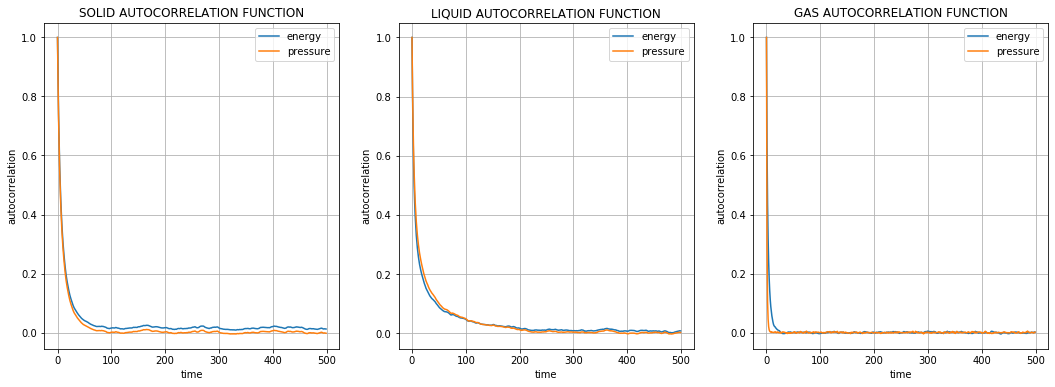

In [128]:
fig, axx = plt.subplots(1, 3,figsize=(18, 6))
scales = [500,500,500]
for i,ax in enumerate(axx):
    ax.plot(t[:scales[i]], auto_en[i][:scales[i]], label = "energy")
    ax.plot(t[:scales[i]], auto_pres[i][:scales[i]], label = "pressure")
    #ax.set_yscale('log')
    ax.set_xlabel('time')
    ax.set_ylabel('autocorrelation')
    ax.set_title(titles[i]+' AUTOCORRELATION FUNCTION')
    ax.legend()
    ax.grid()

Here are the graphs for the autocorrelation functions of the three phases. These are the relaxation (when autocorrelation approaches zero) times:
- solid phase: ~100 steps
- liquid phase: ~300 steps
- gas phase: ~50 steps

It is easy to understand that the gas, being the more caotic system, has the shortest correlation time. On the other hand, it is curious that the correlation time of liquid is longer than the one of solid because, usually, the latter is much less caotic than liquid. This is due to the fact that there is a free parameter that depends on the phase: the Metropolis step.

Now that the correlation time is known, the blocking method can be set up with blocks at least longer than the relaxation time in order to make use of the central limit theorem and calculate the statistical uncertainties. 


#### UNCERTAINTY vs BLOCK LENGTH

In [5]:
def sigma(vect, length):
    nblock = int(len(vect)/length)
    #print(len(vect)/length)
    av = [mean(vect[int(k*length):int((k+1)*length-1)]) for k in range(nblock)]
    av2 = [a**2 for a in av]
    return np.sqrt((mean(av2) - mean(av)**2)/nblock)

In [6]:
%%time
nbins=10
#Ls = np.linspace(10, 5000, nbins)
Ls = [10, 50, 100, 200, 400, 500, 1000, 2000, 4000, 5000]
sigma_en = []
sigma_pres = []
for i in range(3):
    sigma_en.append([sigma(en[i],l) for l in Ls])
    sigma_pres.append([sigma(pres[i],l) for l in Ls])

CPU times: user 44 s, sys: 782 ms, total: 44.8 s
Wall time: 44.8 s


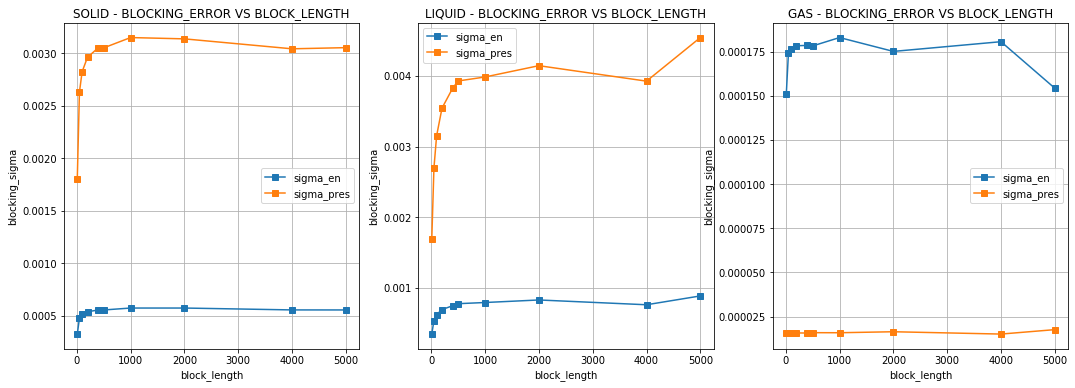

In [7]:
fig, axx = plt.subplots(1,3,figsize=(18,6))
ylims = [0.002,0.002, 0.00002]
for i,ax in enumerate(axx):
    ax.plot(Ls, sigma_en[i], label = 'sigma_en', marker = 's')
    ax.plot(Ls, sigma_pres[i], label = 'sigma_pres', marker = 's')    
    ax.set_xlabel('block_length')
    ax.set_ylabel('blocking_sigma')
    ax.set_title(titles[i]+' - BLOCKING_ERROR VS BLOCK_LENGTH')
    #ax.set_ylim(0, ylims[i])
    ax.grid()
    ax.legend()

These three graphs show the blocking method final uncertainty (for both energy and pressure) versus the block length used. The blocking length goes from $10$ to $5000$ taking values equal to the divisors of $5*10^5$ in order to obtain an integer number of blocks.

Apart from the pressure of the gas phase, in general, an initial rise and a successive saturation charaterize all the functions. This is, in fact, what expected: when the blocks are too short, the CLT does not work, when the blocks are too long, the correlation disappears and the statistical uncertainty remains constant. The error saturates at around $1000$ steps for block.

Now the blocking method can be exploited safely using blocks at least longer than around $1000$ steps.

### EX07_4

#### ENERGY AND PRESSURE, AGAIN

In [41]:
gofr_monte = [[],[],[]]
gofr_dyn = [[],[],[]]
en = [[],[],[]]
pres = [[],[],[]]
for i,ph in enumerate(phases):
    r, gofr, err_gofr = np.loadtxt('gave/gave.'+ph+'.montecarlo.out', usecols=(0,1,2), unpack=True)
    gofr_monte[i].append(r)
    gofr_monte[i].append(gofr)
    gofr_monte[i].append(err_gofr)
    r, gofr, err_gofr = np.loadtxt('gave/gave.'+ph+'.moldyn.out', usecols=(0,1,2), unpack=True)
    gofr_dyn[i].append(r)
    gofr_dyn[i].append(gofr)
    gofr_dyn[i].append(err_gofr)
    iblock, var, err_var = np.loadtxt(ph+'/output.epot.0', usecols=(0,2,3), unpack=True)
    en[i].append(iblock)
    en[i].append(var)
    en[i].append(err_var)
    iblock, var, err_var = np.loadtxt(ph+'/output.pres.0', usecols=(0,2,3), unpack=True)
    pres[i].append(iblock)
    pres[i].append(var)
    pres[i].append(err_var)

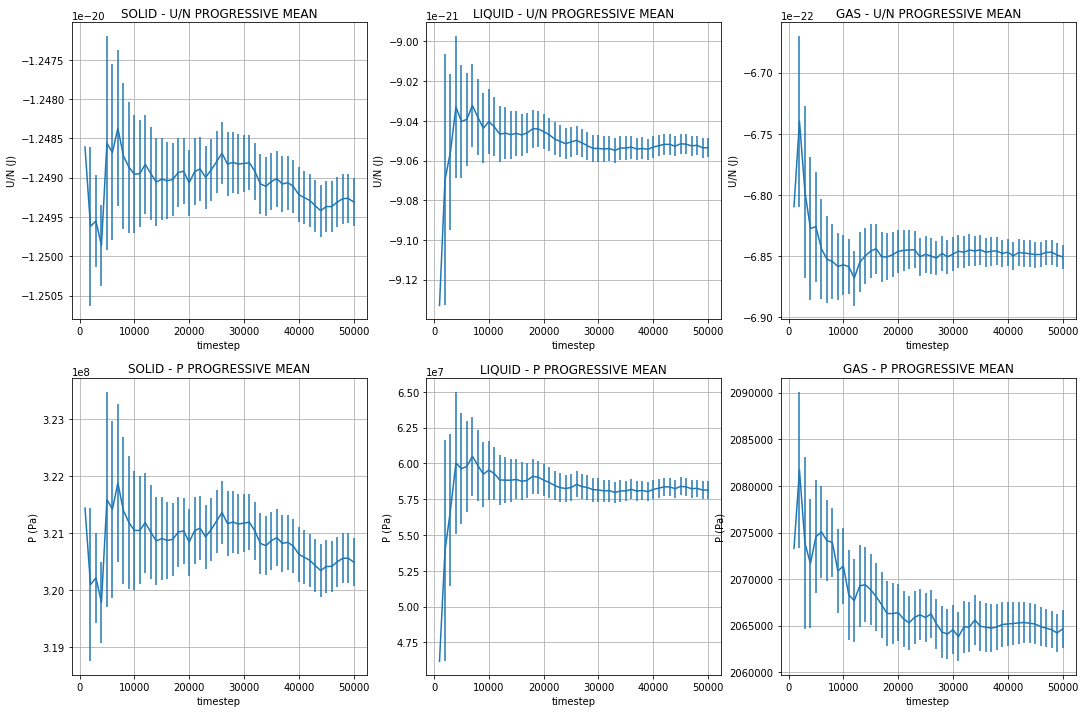

In [54]:
sigma = 0.34e-9
eps_over_kb = 120
m = 39.948*1.66e-27
kb = 1.38e-23
fs = [eps_over_kb*kb, eps_over_kb*kb/sigma**3]

fig, axx = plt.subplots(2,3,figsize=(18,12))
axx = axx.reshape(-1)
labels = ['energy','pressure']

var = [en, pres]

for i in range(6):
    ax = axx[i]
    ax.errorbar(var[int(i/3)][int(i%3)][0]*1000, var[int(i/3)][int(i%3)][1]*fs[int(i/3)], var[int(i/3)][int(i%3)][2]*fs[int(i/3)])
    ax.set_xlabel('timestep')
    ax.set_ylabel(quants[int(i/3)]+' ('+units[int(i/3)]+')')
    ax.set_title(titles[int(i%3)]+' - '+quants[int(i/3)]+' PROGRESSIVE MEAN')
    ax.grid()


Now that there is information on the correlation of the various systems, it is possible to set up the blocking method to measure the potential energy per atom and the pressure. The six graphs above illustrate the progressive mean of each quantity for each phase. It was computed using $50$ blocks of $1000$ steps to ensure the validity of the CLT (after equilibration). In general, all the quantities show a convergence behaviour. The final means and errors are summarized below.

In [60]:
sigma = 0.34e-9
eps_over_kb = 120
m = 39.948*1.66e-27
kb = 1.38e-23
fs = [eps_over_kb*kb, eps_over_kb*kb/sigma**3]
print('==Final means and errors in IS units==')
print('SOLID PHASE:')
print('-Potential energy per atom = '+str(en[0][1][-1]*fs[0])+' +- '+str(en[0][2][-1]*fs[0])+' '+str(units[0]))
print('-Pressure = '+str(pres[0][1][-1]*fs[1])+' +- '+str(pres[0][2][-1]*fs[1])+' '+str(units[1]))
print('LIQUID PHASE:')
print('-Potential energy per atom = '+str(en[1][1][-1]*fs[0])+' +- '+str(en[1][2][-1]*fs[0])+' '+str(units[0]))
print('-Pressure = '+str(pres[1][1][-1]*fs[1])+' +- '+str(pres[1][2][-1]*fs[1])+' '+str(units[1]))
print('GAS PHASE:')
print('-Potential energy per atom = '+str(en[2][1][-1]*fs[0])+' +- '+str(en[2][2][-1]*fs[0])+' '+str(units[0]))
print('-Pressure = '+str(pres[2][1][-1]*fs[1])+' +- '+str(pres[2][2][-1]*fs[1])+' '+str(units[1]))

==Final means and errors in IS units==
SOLID PHASE:
-Potential energy per atom = -1.249307928e-20 +- 3.06520632e-24 J
-Pressure = 320490604.51862407 +- 428990.9627518827 Pa
LIQUID PHASE:
-Potential energy per atom = -9.05353416e-21 +- 4.8389976000000004e-24 J
-Pressure = 58139487.07510685 +- 600017.7081213108 Pa
GAS PHASE:
-Potential energy per atom = -6.85059048e-22 +- 1.0013832e-24 J
-Pressure = 2064653.307551394 +- 2013.2803989415834 Pa


#### THE g(r) FUNCTION

The n-particle distribution function is the rate between the n-particle density of the acutal considered system and the n-particle density of an ideal gas in the same thermodynamic conditions of the system. In this case, we considered the 2-particle radial distribution function $g(r)$. Basically, it expresses the probability of finding two particles at a distance r divided by the same probability for an ideal gas with the same thermodynamic conditions.

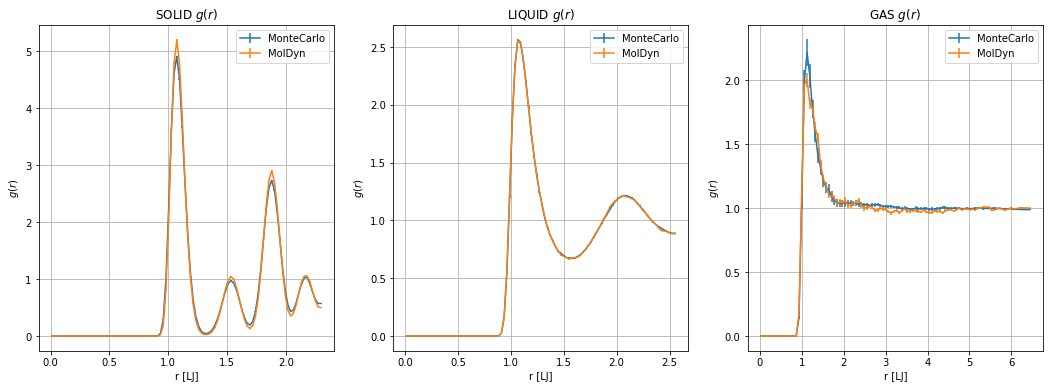

In [63]:
fig, axx = plt.subplots(1,3,figsize=(18,6))
for i,ax in enumerate(axx):
    ax.errorbar(gofr_monte[i][0], gofr_monte[i][1], gofr_monte[i][2], label = 'MonteCarlo')
    ax.errorbar(gofr_dyn[i][0], gofr_dyn[i][1], gofr_dyn[i][2], label = 'MolDyn')
    ax.set_xlabel('r [LJ]')
    ax.set_ylabel(r'$g(r)$')
    ax.set_title(titles[i]+r' $g(r)$')
    ax.grid()
    ax.legend()

These three graphs display a comparison between the $g(r)$ of the three systems considered above and the same three systems in the microcanonical ensamble (see NSL_4). The $g(r)$ is computed using the blocking method on a histogram. This histogram has $100$ equally spaced bins from $r=0$ to $r=box/2$ (half the length of the simulation box) and it is filled checking the distance between couples of particles at each simulation step. The resulitng graph is the final mean of the blocking method for each bin. Obviously, both the microcanonical and canonical ensambles have been equilibrated before the measures.

For all the systems the peak of the distribution is around $r=1$ (LJ units) but it decreases in height: the highest is the solid, then comes the liquid and, in the end, the gas. The presence of more than one peak in the solid and the liquid ensures that the particles of this system tend to stay closer to one another than the gas, which is a more caotic system.

Finally, while the gas phase shows a behaviour similar to an ideal gas for great $r$, the liquid phase oscillates around $g=1$ for high $r$ and the solid phase seems to tend to $1$ much more weakly than the other two  phases. Again, this was expectd because it is clear that the gas phase is the most similar to an ideal gas.

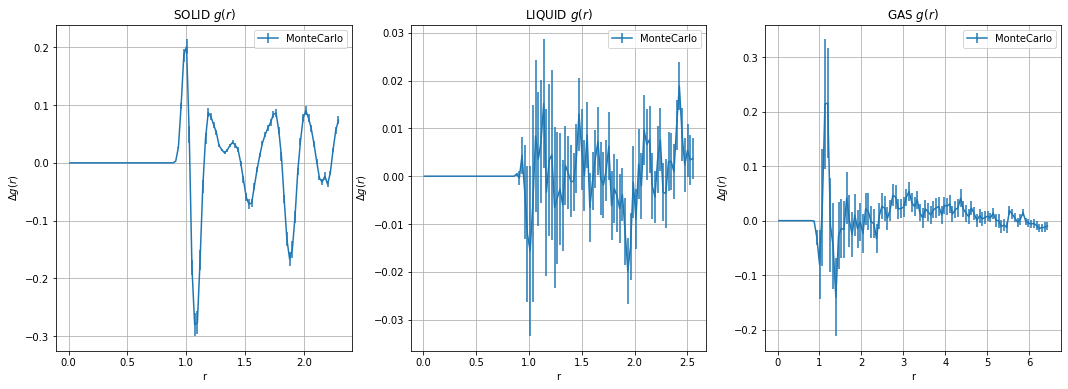

In [64]:
fig, axx = plt.subplots(1,3,figsize=(18,6))
for i,ax in enumerate(axx):
    ax.errorbar(gofr_monte[i][0], gofr_monte[i][1]-gofr_dyn[i][1], np.sqrt(gofr_monte[i][2]**2+gofr_dyn[i][2]**2), label = 'MonteCarlo')
    ax.set_xlabel('r')
    ax.set_ylabel(r'$\Delta g(r)$')
    ax.set_title(titles[i]+r' $g(r)$')
    ax.grid()
    ax.legend()

The most striking thing to observe in the $g(r)$ comparison is that the distribution for the microcanonical and canonical ensambles are practically the same! In these graphs the comparison can be seen with more precision having the difference between the two $g(r)$ on the y axis. From a statistical point of view, it is not possible to say that the canonical and the microcanonical $g(r)$ are completly compatible, especially for the solid phase, but the fact that the general trends are almost overlapped is very interesting.

Essentialy, it means that an open and an isolated systems in similar thermodynamic conditions have the same dsitribution of distances between particles.